In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

Mounted at /content/gdrive


In [2]:
PATH = '/content/gdrive/My Drive/data/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):    
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    gray_clean = tf.identity(image)
    color= tf.identity(image)
    
    gray_clean = tf.cast(gray_clean, tf.float32)
    color = tf.cast(color, tf.float32)
    
    # convert to gray
    gray_clean = tf.image.rgb_to_grayscale(gray_clean)
    
    # make input
    noise = tf.identity(gray_clean)

    noise_level = 25.0
    n = tf.random.normal((IMG_HEIGHT, IMG_WIDTH, 1))*noise_level    
    noise = noise + n

    return noise, gray_clean, color

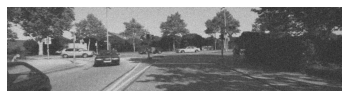

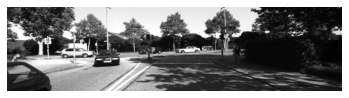

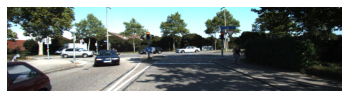

In [3]:
noise, gray_clean, color = load(PATH+'unet/kitti_train/000008_10.png')

# Show the image
plt.figure()
plt.axis('off')
plt.imshow(noise[:,:,0]/255.0, cmap='gray')

plt.figure()
plt.axis('off')
plt.imshow(gray_clean[:,:,0]/255.0, cmap='gray')

plt.figure()
plt.axis('off')
plt.imshow(color/255.0)

In [4]:
# normalizing the images to [-1, 1]
def normalize(input_img, target_img_gray, target_img_color):
    input_img  = (input_img / 127.5) - 1
    target_img_gray = (target_img_gray / 127.5) - 1
    target_img_color = (target_img_color / 127.5) - 1

    return input_img, target_img_gray, target_img_color

def random_jitter(input_img, target_img_gray, target_img_color):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_img  = tf.image.flip_left_right(input_img)
        target_img_gray  = tf.image.flip_left_right(target_img_gray)
        target_img_color = tf.image.flip_left_right(target_img_color)

    return input_img, target_img_gray, target_img_color

def load_image_train(image_file):
    input_img, target_img_gray, target_img_color = load(image_file)
    input_img, target_img_gray, target_img_color = random_jitter(input_img, target_img_gray, target_img_color)
    input_img, target_img_gray, target_img_color = normalize(input_img, target_img_gray, target_img_color)

    return input_img, target_img_gray, target_img_color

def load_image_test(image_file):
    input_img, target_img_gray, target_img_color = load(image_file)
    input_img, target_img_gray, target_img_color = normalize(input_img, target_img_gray, target_img_color)

    return input_img, target_img_gray, target_img_color

In [24]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_train/*.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_test/00000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [6]:
initializer = tf.keras.initializers.HeNormal()

def extract_first_features(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same', 
                                    kernel_initializer=initializer, use_bias=False))    
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

def downsample(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                                    kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

def upsample(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

In [10]:
def UNet_process(x,  OUTPUT_CHANNELS = 3): # (1, 256, 1024, 1)
  # encoding
  down_stack = [
    downsample(64, 4),  # (bs, 128, 512, 64)
    downsample(256, 4), # (bs, 64, 256, 256)
    downsample(512, 4), # (bs, 32, 128, 512)
    downsample(512, 4), # (bs, 16, 64, 512)
    downsample(512, 4), # (bs, 8, 32, 512)
  ]

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])


  # decoding
  up_stack = [
    upsample(512, 4), # (bs, 16, 64, 512)
    upsample(512, 4), # (bs, 32, 128, 512)
    upsample(256, 4), # (bs, 64, 256, 256)
    upsample(64, 4),  # (bs, 128, 512, 64)
  ]

  concat = tf.keras.layers.Concatenate()
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  
  # last layer
   
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,
                                         padding='same', activation='tanh') # (bs, 256, 1024, 3)
  x = last(x)
    
  return x
    
def Generator(): 
    # multiple inputs
    inputs = tf.keras.layers.Input(shape=[256, 1024, 1])    
    x = inputs

    # extract_first_features
    fextract = extract_first_features(64, 3)
    x = fextract(x) # (1,256,1024,64)
       
    # UNet_process
    denoise_gray = UNet_process(x, 1)
    x = denoise_gray

    denoise_color = UNet_process(x, 3)

    return tf.keras.Model(inputs=[inputs], outputs=[denoise_gray, denoise_color])

In [11]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential_19 (Sequential)      (None, 256, 1024, 64 832         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 128, 512, 64) 65792       sequential_19[0][0]              
__________________________________________________________________________________________________
sequential_21 (Sequential)      (None, 64, 256, 256) 263168      sequential_20[0][0]              
______________________________________________________________________________________________

In [12]:
def compute_loss(img1, img2):
  return tf.reduce_mean(tf.abs(img1-img2))

img1 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
img2 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
l1_loss = compute_loss(img1, img2)
print(l1_loss.numpy())

1.1279651


In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

def evaluate(model, epoch):  
    psnr_mean = 0.0
    count = 0
    for input_img, _, output_real in test_dataset:
        denoise, denoise_color = model([input_img], training=True)
         
        psnr = tf.image.psnr(denoise_color*0.5 + 0.5, output_real*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        
        psnr_mean += __psnr_mean
        count =count + 1
    
    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)
    
    return psnr_mean
    
def generate_images(model, input_img, target_img_gray, target_img_color):
    denoise, denoise_color = model([input_img], training=True)
    plt.figure(figsize=(15,20))
    
    display_list = [input_img[0,:,:,0], target_img_color[0], denoise_color[0]]
    title = ['Input Left', 'Real Left', 'Predicted Left']  

    i = 0
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')

    for i in range(1,3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()        

In [22]:
@tf.function
def train_step(input_img, target_img_gray, target_img_color):
    with tf.GradientTape() as gen_tape:
        # output
        denoise, denoise_color = generator([input_img], training=True)
        loss = compute_loss(denoise, target_img_gray) + compute_loss(denoise_color, target_img_color)

    generator_gradients = gen_tape.gradient(loss, generator.trainable_variables)    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return loss    
    
def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        start = time.time()        
       
        # Train
        for input_img, target_img_gray, target_img_color in train_ds:
           loss = train_step(input_img, target_img_gray, target_img_color)
        
        pnsr = evaluate(generator, epoch)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            print(best_pnsr)
             
            for input_img, target_img_gray, target_img_color in test_ds.take(1):
                generate_images(generator, input_img, target_img_gray, target_img_color)


-------- psnr:  23.661016    ----- epoch:  0   count:  10
tf.Tensor(23.661016, shape=(), dtype=float32)


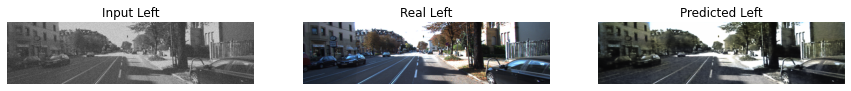

-------- psnr:  23.01456    ----- epoch:  1   count:  10
-------- psnr:  23.419926    ----- epoch:  2   count:  10
-------- psnr:  23.808407    ----- epoch:  3   count:  10
tf.Tensor(23.808407, shape=(), dtype=float32)


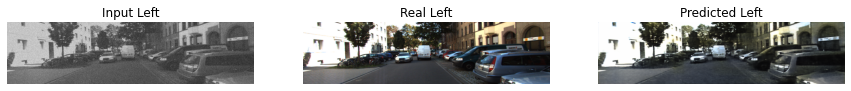

-------- psnr:  23.985092    ----- epoch:  4   count:  10
tf.Tensor(23.985092, shape=(), dtype=float32)


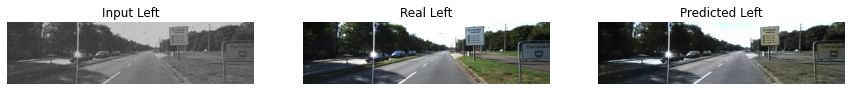

-------- psnr:  23.418545    ----- epoch:  5   count:  10
-------- psnr:  22.931774    ----- epoch:  6   count:  10
-------- psnr:  23.93359    ----- epoch:  7   count:  10
-------- psnr:  23.897099    ----- epoch:  8   count:  10
-------- psnr:  23.500477    ----- epoch:  9   count:  10
-------- psnr:  23.868357    ----- epoch:  10   count:  10
-------- psnr:  24.045193    ----- epoch:  11   count:  10
tf.Tensor(24.045193, shape=(), dtype=float32)


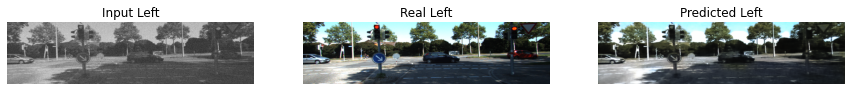

-------- psnr:  23.779093    ----- epoch:  12   count:  10
-------- psnr:  24.16483    ----- epoch:  13   count:  10
tf.Tensor(24.16483, shape=(), dtype=float32)


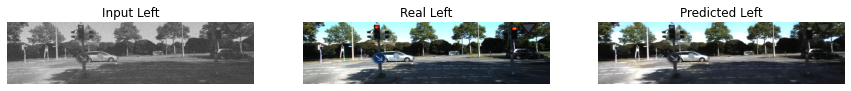

-------- psnr:  23.839048    ----- epoch:  14   count:  10
-------- psnr:  24.046782    ----- epoch:  15   count:  10
-------- psnr:  24.106895    ----- epoch:  16   count:  10
-------- psnr:  23.916264    ----- epoch:  17   count:  10
-------- psnr:  23.957695    ----- epoch:  18   count:  10
-------- psnr:  23.916746    ----- epoch:  19   count:  10
-------- psnr:  24.209866    ----- epoch:  20   count:  10
tf.Tensor(24.209866, shape=(), dtype=float32)


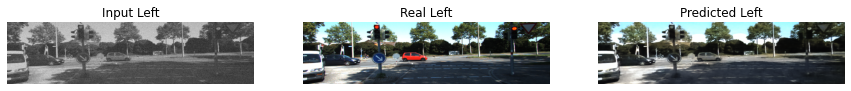

-------- psnr:  23.950228    ----- epoch:  21   count:  10
-------- psnr:  23.993368    ----- epoch:  22   count:  10
-------- psnr:  24.165342    ----- epoch:  23   count:  10
-------- psnr:  24.170296    ----- epoch:  24   count:  10
-------- psnr:  24.315603    ----- epoch:  25   count:  10
tf.Tensor(24.315603, shape=(), dtype=float32)


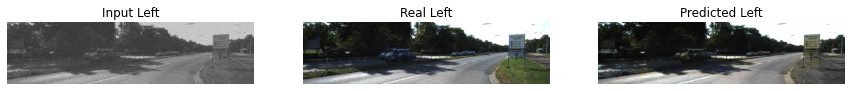

-------- psnr:  24.176746    ----- epoch:  26   count:  10


In [ ]:
EPOCHS = 30
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
# Show the model architecture
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 1024, 64 832         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 512, 64) 65792       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 256, 256) 263168      sequential_1[0][0]               
______________________________________________________________________________________________

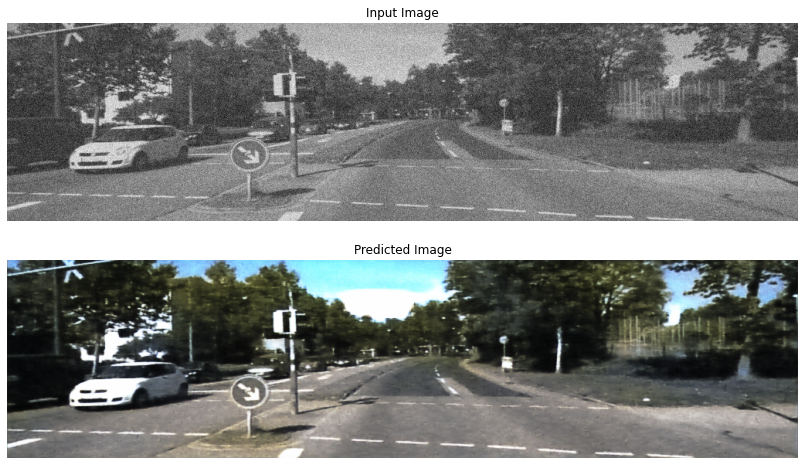

In [ ]:
for inp, tar in test_dataset.take(1):
  fake = generator([inp], training=True)
  plt.figure(figsize=(15,8))
  

  display_list = [inp[0, :, :, 0], fake[0]]
  title = ['Input Image', 'Predicted Image']    

  i = 0
  plt.subplot(2, 1, i+1)
  plt.title(title[i])
  plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
  plt.axis('off')

  i = 1
  plt.subplot(2, 1, i+1)
  plt.title(title[i])
  plt.imshow(display_list[i] * 0.5 + 0.5)
  plt.axis('off')
  plt.show()